In [118]:
# Written by David Gontier
# 29/09/2022

reset

# 2d Case

This is the 2D version of the 1D Keller case. In 2d, the Dirac operator is
$$
    D_m = \begin{pmatrix}
        m & \partial_x - i \partial_y \\ -\partial_x - i \partial_y & -m
    \end{pmatrix}.
$$
We want to find the optimal of
$$
    \inf \left\{ \langle \phi, K_W(\lambda) \phi \rangle,  \quad \| \phi \|_{L^2} = 1, \quad \| W \|_{L^p} = 1 \right\}.
$$
with $2 < p \le \infty$ and
$$
    K_W(\lambda) := \sqrt{W}  R_0(\lambda) \sqrt{W}, \quad \text{with} \quad R_0(\lambda) = (D_m - \lambda)^{-1} = \dfrac{1}{-\Delta + m^2 - \lambda^2} (D_m + \lambda)
$$


In [2]:
%pylab inline
import os
import scipy.sparse.linalg as LA
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [3]:
## The grid to compute the Lp integrals
a = 6                      # we compute quantities on the interval [-a, a]
Nb = 100                    # number of discretization points. Must be even
xx = linspace(-a, a, Nb+1)    # The 1d grid
xx = xx[:Nb]
eps = xx[1] - xx[0]         # the step

xgrid, ygrid = meshgrid(xx, xx)

up, down = range(Nb**2), range(Nb**2, 2*Nb**2)

## The Lp-norm
def Lp_norm(f, p):
    if len(f) == 2*Nb**2:
        # If f is a 2*Nb vector, the first Nb^2 entries are for spin up, and the next Nb^2 for spin down
        absv = sqrt(abs(f[up])**2 + abs(f[down])**2)
        integral = sum(absv**p)*eps**2
        return integral**(1/p)
    else: # for the potential, non spins
        integral = sum(abs(f)**p )*eps**2
        return integral**(1/p)

We compute the Dirac operator (and its inverse), in Fourier space. Writing (with Python convention)
$$
    f(x) = \sum_{k=-M}^M f_k \exp ( - i k \frac{2 \pi }{2 a} x),
$$
we access the coefficients $v_k$ with `fft.fft(v)` (and some shifts), and the operator $(- i \partial_x)$ becomes the multiplication by $-\frac{\pi}{a} k$.

In [4]:
m = 1 # the mass

######################################
def get_Dirac(Nb, λ = 0):
    # returns the operator (Dirac - λ)

    K = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes (with the correct shift)
    Kx, Ky = meshgrid(K, K)

    def mult_Dirac(w):
        w_up, w_down = reshape(w[up], (Nb, Nb)), reshape(w[down], (Nb, Nb))
        w_up_fft, w_down_fft = fft.fft2(w_up), fft.fft2(w_down)
        
        res_up_fft = (m - λ)*w_up_fft + (1j*Kx - Ky)*w_down_fft
        res_down_fft = (-1j*Kx - Ky)*w_up_fft - (m + λ)*w_down_fft

        res = zeros(2*Nb**2, dtype='complex')
        res[up] = reshape( fft.ifft2(res_up_fft) , Nb**2 )
        res[down] = reshape( fft.ifft2(res_down_fft) , Nb**2)

        return res
    return LA.LinearOperator((2*Nb**2, 2*Nb**2), matvec = mult_Dirac)

#########################################
def get_Dirac_inverse(Nb, λ = 0):
    # returns the operator (Dirac - λ)^{-1}

    K = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes (with the correct shift)
    Kx, Ky = meshgrid(K, K)

    def mult_Dirac_m1(w):

        w_up, w_down = reshape(w[up], (Nb, Nb)), reshape(w[down], (Nb, Nb))
        w_up_fft, w_down_fft = fft.fft2(w_up), fft.fft2(w_down)
        
        res_up_fft = (m + λ)*w_up_fft + (1j*Kx - Ky)*w_down_fft
        res_down_fft = (-1j*Kx - Ky)*w_up_fft - (m - λ)*w_down_fft

        res_up_fft *= 1/(Kx**2 + Ky**2 + m**2 - λ**2)
        res_down_fft *= 1/(Kx**2 + Ky**2 + m**2 - λ**2)

        res = zeros(2*Nb**2, dtype='complex')
        res[up] = reshape( fft.ifft2(res_up_fft) , Nb**2 )
        res[down] = reshape( fft.ifft2(res_down_fft) , Nb**2)

        return res
    
    return LA.LinearOperator((2*Nb**2, 2*Nb**2), matvec = mult_Dirac_m1)

In [5]:
#################################
# Check cell

Dirac, Dirac_m1 = get_Dirac(Nb), get_Dirac_inverse(Nb)

print("Check self-adjointness")
u = rand(2*Nb**2) + 1j*rand(2*Nb**2)
v = rand(2*Nb**2) + 1j*rand(2*Nb**2)
print("\t must be 0 : ", norm ( dot(conj(u),Dirac@v) - dot(conj(Dirac@u), v)) )

print("Check invertibility")
u = rand(2*Nb**2) + 1j*rand(2*Nb**2)
print("\t must be 0 : ", norm ( Dirac_m1@(Dirac@u) - u ) )

Check self-adjointness
	 must be 0 :  3.2155493553843714e-12
Check invertibility
	 must be 0 :  5.315148634732275e-14


We compute the infimum problem with a self-consistent loop. We set $\phi_n$ the highest normalized eigenvector of $K_{W_n}(\lambda)$, and set
$$
    W_{n+1} = | \phi_n |^{2/p}.
$$

In [6]:
def get_W(phi, p):
    phi_up, phi_down = reshape(phi[up], (Nb, Nb)) , reshape(phi[down], (Nb, Nb))
    W = (abs(phi_up)**2 + abs(phi_down)**2)**(1/p)
    # Shift to center
    imax = argmax(W)
    i, j = imax//Nb, mod(imax, Nb)
    W1 = roll( W, -i + Nb//2, axis=0)
    W2 = roll(W1, -j + Nb//2, axis=1)
    return W2

def get_KW(W, Dirac_m1=Dirac_m1):
    def mult_op(phi):
        sqrtW = zeros(2*Nb**2)
        sqrtW[up] = reshape(W**(1/2), Nb**2)
        sqrtW[down] = reshape(W**(1/2), Nb**2)

        phi1 = sqrtW*phi
        phi2 = Dirac_m1@phi1
        phi3 = sqrtW*phi2
        return phi3
    
    return LA.LinearOperator((2*Nb**2, 2*Nb**2), matvec = mult_op)

def energy(KW, phi):
    return real( dot(conj(phi), KW@phi)*eps**2 )

In [7]:
def get_optimalW(λ, p):

    Wrecord = []
    
    print("\n\nComputation for p = {} and λ = {}".format(p, λ))

    # Initialization vector
    phi0 = zeros(2*Nb**2, dtype='complex')
    phi0 = rand(2*Nb**2) + 1j*rand(2*Nb**2)
    phi0 = phi0/Lp_norm(phi0, 2)
    W0 = get_W(phi0, p)

    # Parameters of the loop
    Niter = 100    # maximal number of iterations
    tol = 1e-7      # tolerance

    ################################
    Dirac_m1 = get_Dirac_inverse(Nb, λ)

    #################################
    # Main loop
    En, Wn, phin = -1, W0, phi0

    for n in range(Niter):
        KWn = get_KW(Wn, Dirac_m1)
        eigval, eigvec = LA.eigsh(KWn, k=1, which='LA') #largest eigenvector
        
        phinp1, Enp1 = eigvec[:,0], eigval[0]
        phinp1 = phinp1/Lp_norm(phinp1, 2)

        if Enp1 < En:
            print("problem, the energy is not increasing...")
            break

        Wnp1 = get_W(phinp1, p)
        if norm(Wnp1 - Wn) < tol:
            break

        if mod(n, 10) == 0: #print
            print("\tIteration n = {:4}, Energy = {}, norm = {}".format(n, En, norm(Wnp1 - Wn)),)

        En, Wn, phin = Enp1, Wnp1, phinp1
        Wrecord.append(Wn)

    phistar, Wstar, tau = phin, Wn, Enp1
    print("\n\tDone. Number of iterations = {}, Energy = {:.4}, tau = {:.4}".format(n, En, tau))
    return Wstar, Wrecord

In [8]:
## Test cell
p = 3
λ = 0.5

Wstar, Wrecord = get_optimalW(λ, p)




Computation for p = 3 and λ = 0.5
	Iteration n =    0, Energy = -1, norm = 2.031457381733651
	Iteration n =   10, Energy = 0.5557739978815341, norm = 0.5813572680264228
	Iteration n =   20, Energy = 0.5613221598922968, norm = 0.008178479730057751
	Iteration n =   30, Energy = 0.5613236172451818, norm = 0.0001324580865701469
	Iteration n =   40, Energy = 0.5613236176318604, norm = 2.157262119948194e-06
problem, the energy is not increasing...

	Done. Number of iterations = 46, Energy = 0.5613, tau = 0.5613


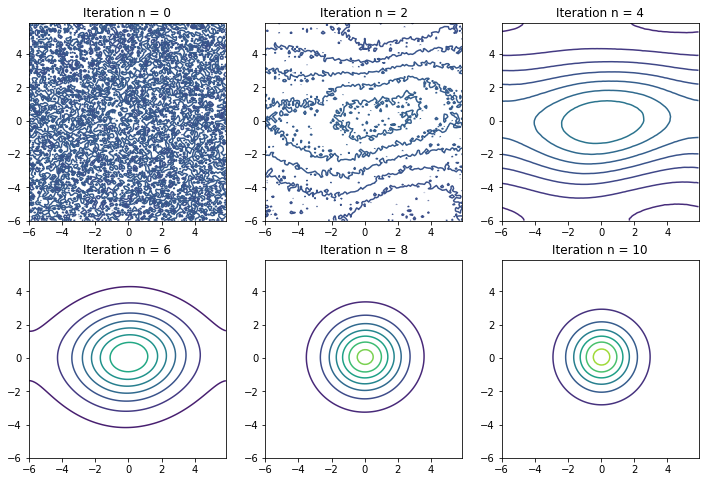

In [9]:
figsize(12, 8)

for i in range(6):
    subplot(2,3,i+1)
    snapshot =  2*i
    W = Wrecord[snapshot]

    contour(xx, xx, W, vmin=0, vmax = 0.7)
    #colorbar()
    axis('equal')
    title("Iteration n = {}".format(snapshot))

#savefig("Wn_movie.png", bbox_inches = 'tight')

## Check radiality

We compute dtheta of a function with the formula
$$
    \partial_θ = - r \sin θ ⋅ \partial_x f + r \cos θ ⋅ \partial_y f = -y ⋅  \partial_x f + x ⋅ \partial_y f
$$

In [10]:
def dtheta(F):
    dxF = (roll(F, 1, axis=1) - roll(F, -1, axis=1))/eps/2
    dyF = (roll(F, 1, axis=0) - roll(F, -1, axis=0))/eps/2
    return -ygrid*dxF + xgrid*dyF 

In [11]:
dtheta_W = dtheta(Wstar)

Lp_norm(dtheta_W, p)

0.03360718431915104